## Load Required Packages

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import json
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import QuantileTransformer
from pyEDM import *

## Load Data

In [2]:
# Load NPP-Satellite matchups
npp = xr.open_dataset('../data/npp_satellite_matchups_reduced_dataset.nc')

## Code to Make Scatter Plot

In [3]:
def make_scatter_plot(result_df, model_name, ax=None):

    # # Calculate summary statistics (on log-transformed data)
    result_df = result_df[['Integrated_NPP', f'Satellite_NPP ({model_name})', f'Satellite_NPP_std ({model_name})']].copy().dropna()

    # Filter out zeros and NaNs before log transformation
    # Log(0) is -inf, which breaks the regression
    mask = (result_df['Integrated_NPP'] > 0) & (result_df[f'Satellite_NPP ({model_name})'] > 0)
    result_df = result_df[mask].dropna()

    log_x = np.log10(result_df['Integrated_NPP'].values)
    log_y = np.log10(result_df[f'Satellite_NPP ({model_name})'].values)

    # Linear regression in log-log space
    model = LinearRegression()
    model.fit(log_x.reshape(-1, 1), log_y)
    log_y_pred = model.predict(log_x.reshape(-1, 1))
    r2 = r2_score(log_y, log_y_pred)
    rmse = np.sqrt(mean_squared_error(log_y, log_y_pred))
    rmsd = np.sqrt(np.mean((log_y - log_y_pred)**2))
    slope = model.coef_[0]
    intercept = model.intercept_
    corr = np.corrcoef(result_df['Integrated_NPP'], result_df[f'Satellite_NPP ({model_name})'])[0,1]
    log_corr = np.corrcoef(log_x, log_y)[0,1]
    n = len(result_df)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))

    ax.errorbar(
        result_df['Integrated_NPP'],
        result_df[f'Satellite_NPP ({model_name})'],
        yerr=result_df[f'Satellite_NPP_std ({model_name})'],
        fmt='none',           # no marker (we already have scatterplot)
        ecolor='gray',        # color of error bars
        alpha=0.4,            # transparency
        capsize=2,            # caps on error bars
        elinewidth=1,
        label='\'b11 Std Dev',
        zorder=1
    )

    # Re-transform regression line to original scale
    x_range = np.logspace(np.log10(result_df['Integrated_NPP'].min()), np.log10(result_df['Integrated_NPP'].max()), 100)
    y_fit = 10 ** model.predict(np.log10(x_range).reshape(-1, 1))

    if ax is None:
        sns.scatterplot(data=result_df, x='Integrated_NPP', y=f'Satellite_NPP ({model_name})', s=20, alpha=0.8)
    else:
        sns.scatterplot(data=result_df, x='Integrated_NPP', y=f'Satellite_NPP ({model_name})', ax=ax, s=20, alpha=0.8)

    # Add regression line
    ax.plot(x_range, y_fit, color='red', label='Regression line')

    # Add 1:1, 1:2, and 1:3 lines
    min_val = min(result_df[['Integrated_NPP', f'Satellite_NPP ({model_name})']].min())
    max_val = max(result_df[['Integrated_NPP', f'Satellite_NPP ({model_name})']].max())
    ax.plot(x_range, x_range, 'k--', label='1:1 line', alpha=0.5)
    ax.plot(x_range, x_range / 2, 'k:', label='1:2 line', alpha=0.5)
    ax.plot(x_range, x_range / 3, 'k-.', label='1:3 line', alpha=0.5)

    # Labels, scales, title
    ax.set_xlabel('In situ NPP (mg C/m\'b2/day)')
    ax.set_ylabel(f'Satellite NPP ({model_name})')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Satellite vs. In Situ NPP ({model_name})')

    # ax.set_xlim(10**1.75, 10**4)
    # ax.set_ylim(10**1.75, 10**4)

    # Add R^2, RMSE, N as text
    ax.text(0.05, 0.95,
            f'$R^2$ = {r2:.2f}\n'
            f'RMSE = {rmse:.2f}\n'
            f'RMSD = {rmsd:.2f}\n'
            f'Slope = {slope:.3f}\nIntercept = {intercept:.3f}\n'
            f'Corr = {corr:.3f}\n'
            f'Corr (log-log) = {log_corr:.3f}\n'
            f'N = {n}',
            transform=ax.transAxes,
            verticalalignment='top',
            fontsize=9,
            bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    ax.grid(True, which='both', ls=':')
    ax.legend(loc='lower right')

    return ax

## Eppley Square Root Model (ESQRT)

/Users/deliacarpenter/miniconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


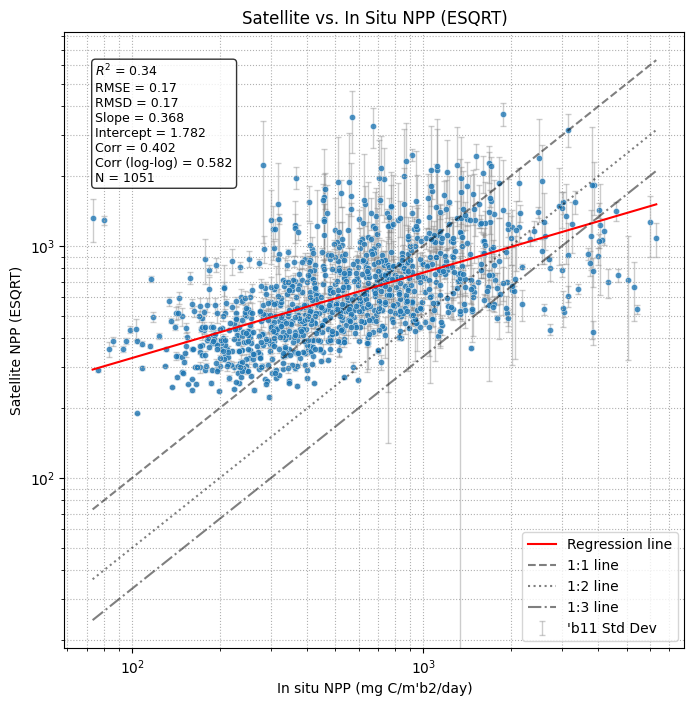

In [4]:
ds = npp.copy()

# 1. Access the CHL data variable
chl_data = ds['CHL_value_0']

# 2. Apply ESQRT model (NPP = 1000 * sqrt(CHL)) for every pixel at once
npp_cube = 1000 * np.sqrt(chl_data)

# 3. Average the n x n grids.
npp_mean = npp_cube.mean(dim=['y_grid', 'x_grid'])
npp_std = npp_cube.std(dim=['y_grid', 'x_grid'])

# 4. Add these results back into your dataset as new variables
ds['Satellite_NPP (ESQRT)'] = npp_mean
ds['Satellite_NPP_std (ESQRT)'] = npp_std

# 5. Select only the 1D result variables from Xarray
plot_df = ds[['Integrated_NPP', 'Satellite_NPP (ESQRT)', 'Satellite_NPP_std (ESQRT)']].to_dataframe()

# 7. Plot results
model_name = "ESQRT"
fig, ax = plt.subplots(figsize=(8, 8))
make_scatter_plot(plot_df, model_name, ax=ax)
plt.show()

## Vertically Generalized Production Model (VGPM)

/Users/deliacarpenter/miniconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


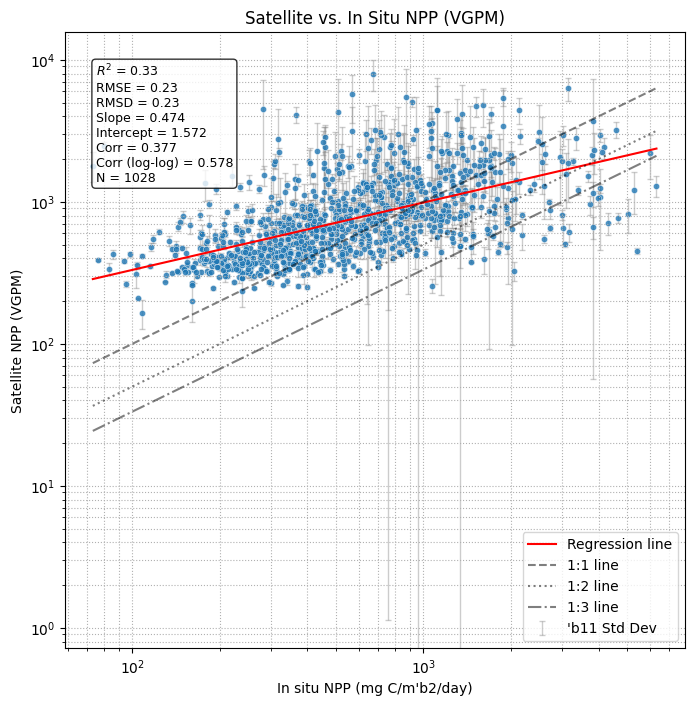

In [5]:
def vgpm(ds):
    # 1. Set up variables (ensuring strictly positive for logs/sqrt)
    chl = ds['CHL_value_0'].where(ds['CHL_value_0'] > 0)
    par = ds['PAR_value_0'].where(ds['PAR_value_0'] > 0)
    sst = ds['SST_value_0']

    # Handle Kelvin to Celsius conversion if needed
    if sst.mean() > 200:
        sst = sst - 273.15

    # 2. chl_tot and z_eu (Euphotic Depth)
    # Using xr.where(condition, if_true, if_false)
    chl_tot = xr.where(chl < 1.0, 38 * chl**0.425, 40.2 * chl**0.507)
    z_eu = 200.0 * chl_tot**(-0.293)
    z_eu = xr.where(z_eu <= 102.0, 568.2 * chl_tot**(-0.746), z_eu)

    # 3. pb_opt (The temperature-dependent optimal productivity)
    # This is the 7th-order polynomial from Behrenfeld & Falkowski (1997)
    pb_opt = (1.2956 + 0.2749 * sst + 0.0617 * sst**2 - 0.0205 * sst**3 + 
              0.002462 * sst**4 - 0.0001348 * sst**5 + 
              3.4132e-6 * sst**6 - 3.27e-8 * sst**7)

    # Apply temperature constraints
    pb_opt = xr.where(sst < 1.0, 1.13, pb_opt)
    pb_opt = xr.where(sst < -10.0, 0.0, pb_opt)
    pb_opt = xr.where(sst > 28.5, 4.0, pb_opt)

    # 4. Irradiance function
    irr_func = 0.66125 * par / (par + 4.1)

    # 5. Calculate NPP for each pixel
    npp_cube = pb_opt * chl * ds['day_length'] * irr_func * z_eu

    return npp_cube

# Run VGPM model
npp_cube = vgpm(ds)

# Average the n x n grids.
npp_mean = npp_cube.mean(dim=['y_grid', 'x_grid'])
npp_std = npp_cube.std(dim=['y_grid', 'x_grid'])

# Add these results back into your dataset as new variables
ds['Satellite_NPP (VGPM)'] = npp_mean
ds['Satellite_NPP_std (VGPM)'] = npp_std

# 5. Select only the 1D result variables from Xarray
plot_df = ds[['Integrated_NPP', 'Satellite_NPP (VGPM)', 'Satellite_NPP_std (VGPM)']].to_dataframe()

# 7. Plot results
model_name = "VGPM"
fig, ax = plt.subplots(figsize=(8, 8))
make_scatter_plot(plot_df, model_name, ax=ax)
plt.show()

## EDM

In [6]:
# Normalize satellite data for EDM

def quantile_transform(da, skip_vars, use_zscore=True):
    """
    Using a quantile transform because of extreme skewness in the satellite data.
    This transforms the data into a uniform distribution between [0,1] by ranking the values. 
    """
    
    if da.name in skip_vars or not np.issubdtype(da.dtype, np.number):
        return da

    vals = da.values.reshape(-1, 1)
    mask = np.isfinite(vals)
    clean_vals = vals[mask].reshape(-1, 1)

    # use Quantile Transform to force a uniform distribution
    qt = QuantileTransformer(output_distribution='uniform', n_quantiles=1000)
    transformed = qt.fit_transform(clean_vals)

    # 4. Reconstruct xarray
    res_vals = np.full_like(vals, np.nan)
    res_vals[mask] = transformed.flatten()
    
    return da.copy(data=res_vals.reshape(da.shape))

# List of variables to skip
skip_vars = ['Sta_ID', 'Date', 'regime', 'Latitude', 'Longitude', 'Integrated_NPP']
npp_norm = npp.map(quantile_transform, args=(skip_vars,))

In [7]:
# --- EDM SECTION: STEP 1 (Manifold Reconstruction) ---

# Choose embedding columns for state-space reconstruction
embedding_cols = ['SST_value_0', 'CHL_value_0']
target = 'Integrated_NPP'

# Flatten the 3D array (station_obs, y_grid, x_grid) into a 2D "stacked" table for the EDM library. 
# We will be using every available pixel as our library set (excluding pixels that belong to the same NPP observation)
df_stacked = npp_norm[embedding_cols + [target]].to_dataframe().reset_index()

# Sort by Date/Sta_ID to ensure pixels from the same day are in a block
df_stacked = df_stacked.sort_values(['Date', 'Sta_ID']).reset_index(drop=True)
to_edm = df_stacked[[target] + embedding_cols]

# Define the exclusion radius (so that pixels from the same day are not included in the library -- that would be cheating)
exc_rad = 49
lib = f'1 {len(to_edm)}'
pred = lib

# Cross-map from the embedding_cols to the target
xmap = Simplex(dataFrame=to_edm,
               columns=embedding_cols,
               target=target,
               lib=lib,
               pred=pred,
               embedded=True,
               exclusionRadius=exc_rad,
               noTime=True
              )

#xmap = xmap[['Observations', 'Predictions']]
#xmap.columns = ['Integrated_NPP', 'Satellite_NPP (EDM)']

/Users/deliacarpenter/miniconda3/lib/python3.12/site-packages/pyEDM/Neighbors.py:247: UserWarning: Simplex: FindNeighbors() : ExclusionRad() Failed to find knn outside exclusionRadius 49. Returning orginal knn. Consider to reduce knn 3.
  warn( msg )


/Users/deliacarpenter/miniconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


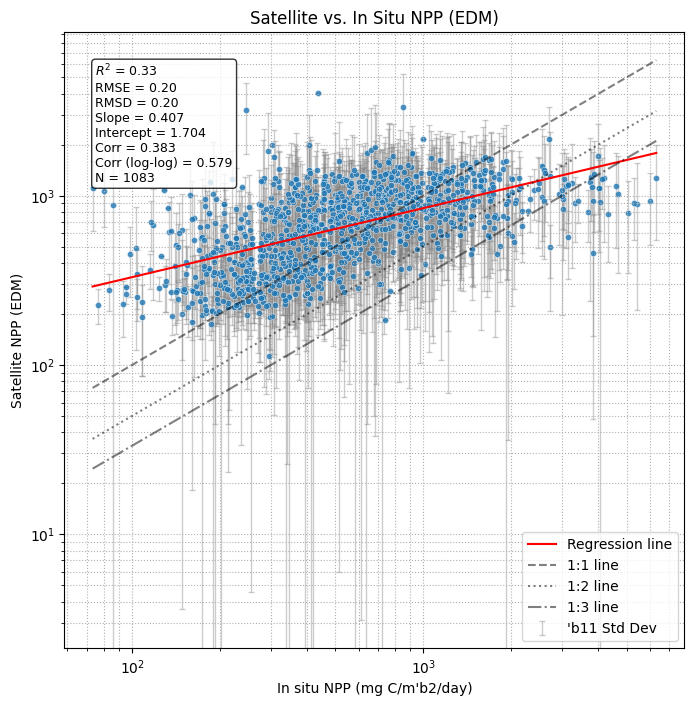

In [8]:
# --- EDM SECTION: STEP 2 (Unstacking & Spatial Averaging) ---

# Organize the flat predictions back into the original 3D grid format (station_obs, y_grid, x_grid)
xmap[['station_obs', 'y_grid', 'x_grid']] = df_stacked[['station_obs', 'y_grid', 'x_grid']]
df_pivot = xmap.set_index(['station_obs', 'y_grid', 'x_grid'])

# Convert to a Dataset to hold our 3D grid results
prediction_ds = df_pivot['Predictions'].to_xarray().to_dataset(name='Satellite_NPP_Grid')
prediction_ds = prediction_ds.reindex_like(npp_norm)

# Spatial Averaging: 
# We calculate the mean and standard deviation across the 7x7 grid for each observation.
# This gives us a single 'Satellite NPP' value and an uncertainty estimate.
spatial_mean = prediction_ds['Satellite_NPP_Grid'].mean(dim=['y_grid', 'x_grid'])
spatial_std = prediction_ds['Satellite_NPP_Grid'].std(dim=['y_grid', 'x_grid'])

# Final Assembly
# Add the 1D results and the original in-situ data back into one object
prediction_ds['Integrated_NPP'] = npp_norm['Integrated_NPP']
prediction_ds['Satellite_NPP (EDM)'] = spatial_mean
prediction_ds['Satellite_NPP_std (EDM)'] = spatial_std

# Convert back to a 2D DataFrame for plotting and evaluation
plot_df = prediction_ds[['Integrated_NPP', 'Satellite_NPP (EDM)', 'Satellite_NPP_std (EDM)']].to_dataframe()
plot_df = plot_df.dropna(subset=['Satellite_NPP (EDM)'])

# Plot results
model_name = "EDM"
fig, ax = plt.subplots(figsize=(8, 8))
make_scatter_plot(plot_df, model_name, ax=ax)
plt.show()